# Simple MFA with Numpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's think about the stock of silicon needed for photovoltaics, and the flows into and out of the system. This could be interesting for us to change the amount of recycled silicon in PV manufacture, and to increase energy efficiency as production scales.

We will fix in advance:

* Energy demand (function of time)
* Silicon intensity of PV generation (function of time)
* Survival curve of PV modules (time invariant)
* Demand for PV electricity is perfectly met with new supply

We will need to do MFA to determine:

* The amount of PV installed per year (function of time)
* The fleet of installed PV capacity (function of time)
* The flow of primary silicon into and secondary silicon out of the fleet (per year) 

Text(0, 0.5, 'Energy')

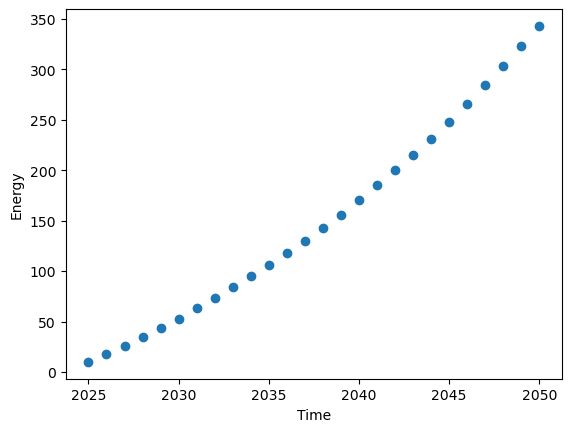

In [8]:
energy_demand_df = (
    pd.read_csv('PV_demand.csv')
    .rename(columns={"Scenario 2 - Solar production [TWh/a]": "Demand"})
    .drop(columns=["Scenario 1 - Solar production [TWh/a]"]) 
)
time = energy_demand_df['Year'].to_numpy()
demand = energy_demand_df['Demand'].to_numpy() * 100

plt.scatter(time, demand)
plt.xlabel("Time")
plt.ylabel("Energy")

We will make up data. The first thing we need to make up is the silicon intensity of PV. This will decrease over time. Because we are making up data, we don't need to worry about if the numbers are reasonable.

Text(0, 0.5, 'Silicon per energy')

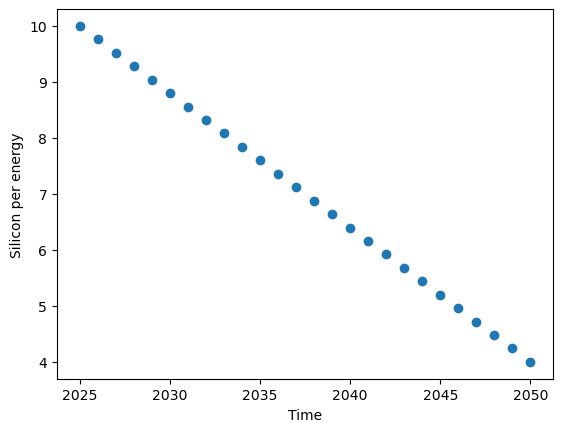

In [31]:
silicon_intensity = np.linspace(10, 4, len(time))

plt.scatter(time, silicon_intensity)
plt.xlabel("Time")
plt.ylabel("Silicon per energy")

Our PV modules don't have a fixed lifetime - rather, some fraction of the fleet leaves each year. This survival function is fixed.

Text(0, 0.5, 'Surviving Fraction')

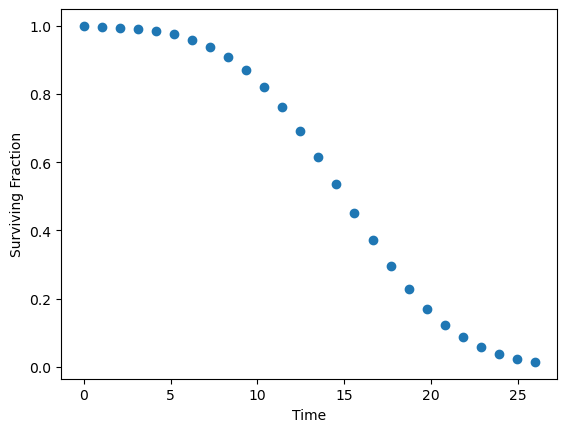

In [25]:
from scipy import stats

median_age_guess = 15
std_dev_guss = 5
survival_fraction = stats.norm.sf(np.linspace(0, len(time), len(time)), loc=median_age_guess, scale=std_dev_guss)
# Fix 100% for first year
survival_fraction[0] = 1

plt.scatter(np.linspace(0, len(time), len(time)), survival_fraction)
plt.xlabel("Time")
plt.ylabel("Surviving Fraction")

We now need a suitable data structure which will tell us, _for each year_, the amount of silicon PV installed. This will be our first axis (axis 0, as Python is 0-indexed).

For each year, we can also think not just about the _total_ but rather the temporal origin of all the different PV installations used in that year. In the first year this will be 100% from the first year (because in our model nothing existing prior to 2025). Over time, some PV will leave as it reaches end-of-life, and some PV will be added. This will be our second axis (axis 1).

We also don't care about anything after our time series ends, so our data structure will be a 2-dimensional array, and each dimension with have the same length as `time`.

In [26]:
stocks_by_year_of_origin = np.zeros(shape=(len(time), len(time)))

In [27]:
for index, year in enumerate(time):
    installation_this_year = (
        demand[0] 
        if index == 0 
        else demand[index] - stocks_by_year_of_origin[index - 1, :].sum() 
    )
    # Only need to take values from survival fraction until end of model run
    stocks_by_year_of_origin[index:len(time), index] = installation_this_year * survival_fraction[:len(time) - index]

Figure out the total energy generation over each year. This will be roughly the same as the demand (it should be exact, not sure where we are losing mass).

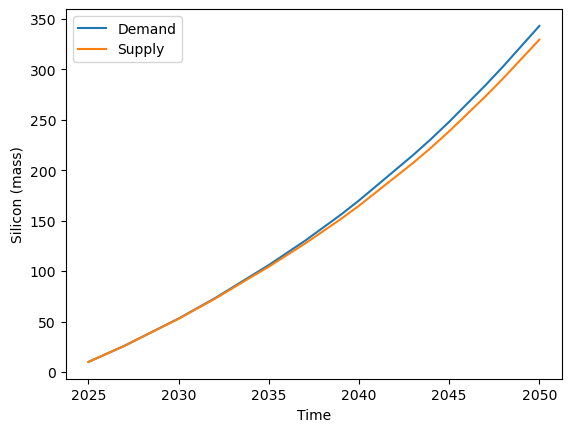

In [76]:
cumulative_sum = stocks_by_year_of_origin.cumsum(axis=1)

plt.plot(time, demand, label="Demand")
plt.plot(time, cumulative_sum[:, -1], label="Supply")
plt.xlabel("Time")
plt.ylabel("Silicon (mass)")
plt.legend()

We can now visualize the PV fleet by age cohort.

The following graphs use the `vanimo` colormap. You can [pick your own colormap](https://matplotlib.org/stable/gallery/color/colormap_reference.html) if you prefer different colors.

In [57]:
COLORMAP_LABEL = 'vanimo'

Text(0.5, 1.0, 'Global installed PV energy generation')

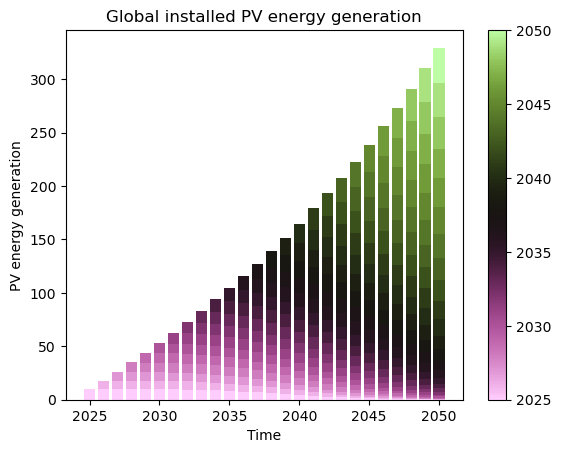

In [78]:
import matplotlib as mpl

colors = mpl.colormaps[COLORMAP_LABEL](np.linspace(0, 1, len(time)))


for index, year in enumerate(time):
    for cohort, cohort_year in enumerate(time):
        amount = stocks_by_year_of_origin[index, cohort]
        if not amount:
            continue
        plt.bar(
            x=year, 
            height=amount,
            bottom=(0 if cohort == 0 else cumulative_sum[index, cohort - 1]),
            color=colors[cohort]
        )

mappable = mpl.cm.ScalarMappable(cmap=mpl.colormaps[COLORMAP_LABEL])
mappable.set_array(time)
plt.colorbar(mappable=mappable, ax=plt.gca())

plt.xlabel("Time")
plt.ylabel("PV energy generation")
plt.title("Global installed PV energy generation")

However, this isn't the total amount of silicon - remember, we fixed in advance that the silicon intensity would decrease over time. Let's plot the total amount of installed silicon.

Text(0.5, 1.0, 'Global installed silicon stock')

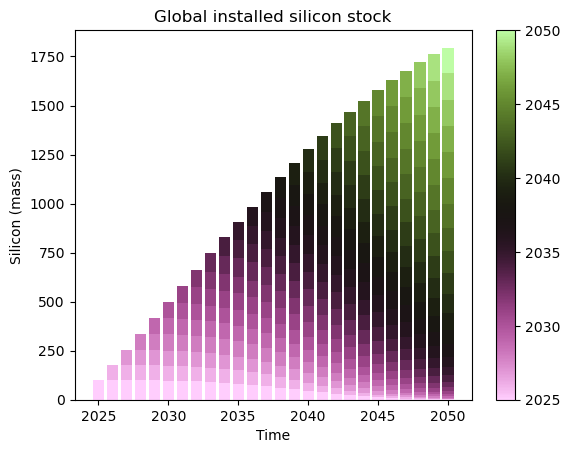

In [79]:
installed_silicon = silicon_intensity * stocks_by_year_of_origin
cumulative_sum_silicon = installed_silicon.cumsum(axis=1)

for index, year in enumerate(time):
    for cohort, cohort_year in enumerate(time):
        amount = installed_silicon[index, cohort]
        if not amount:
            continue
        plt.bar(
            x=year, 
            height=amount,
            bottom=(0 if cohort == 0 else cumulative_sum_silicon[index, cohort - 1]),
            color=colors[cohort]
        )

plt.colorbar(mappable=mappable, ax=plt.gca())

plt.xlabel("Time")
plt.ylabel("Silicon (mass)")
plt.title("Global installed silicon stock")

We can also visualize flow of silicon out of the system:

Text(0.5, 1.0, 'Global silicon recovery')

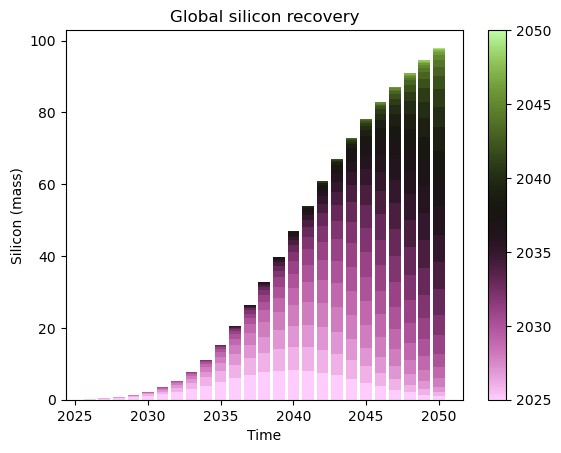

In [80]:
removed_silicon = np.zeros_like(installed_silicon)
removed_silicon[1:, :] = installed_silicon[:-1, :] - installed_silicon[1:, :]
np.fill_diagonal(removed_silicon, 0)
cumulative_removed_silicon = removed_silicon.cumsum(axis=1)

for index, year in enumerate(time):
    for cohort, cohort_year in enumerate(time):
        amount = removed_silicon[index, cohort]
        if not amount:
            continue
        plt.bar(
            x=year, 
            height=amount,
            bottom=(0 if cohort == 0 else cumulative_removed_silicon[index, cohort - 1]),
            color=colors[cohort]
        )

plt.colorbar(mappable=mappable, ax=plt.gca())

plt.xlabel("Time")
plt.ylabel("Silicon (mass)")
plt.title("Global silicon recovery")

Finally, we assume that our recovery process is 100% efficient, and that all recovered silicon is used in manufacture of new PV. We can then calculate the fraction of secondary silicon in PV manufacture:

Text(0, 0.5, 'Recycled silicon fraction')

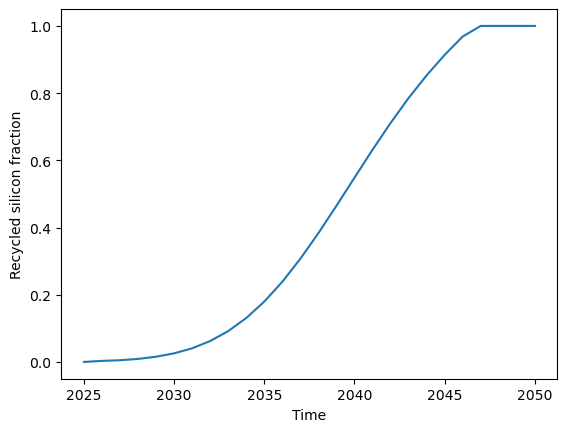

In [81]:
silicon_addition = installed_silicon.sum(axis=1)
silicon_addition = np.max(silicon_addition[1:] - silicon_addition[:-1], 0)

fraction_recycled_silicon = np.minimum(removed_silicon.sum(axis=1) / silicon_addition, 1)

plt.plot(time, fraction_recycled_silicon)

plt.xlabel("Time")
plt.ylabel("Recycled silicon fraction")

# Integration with LCA

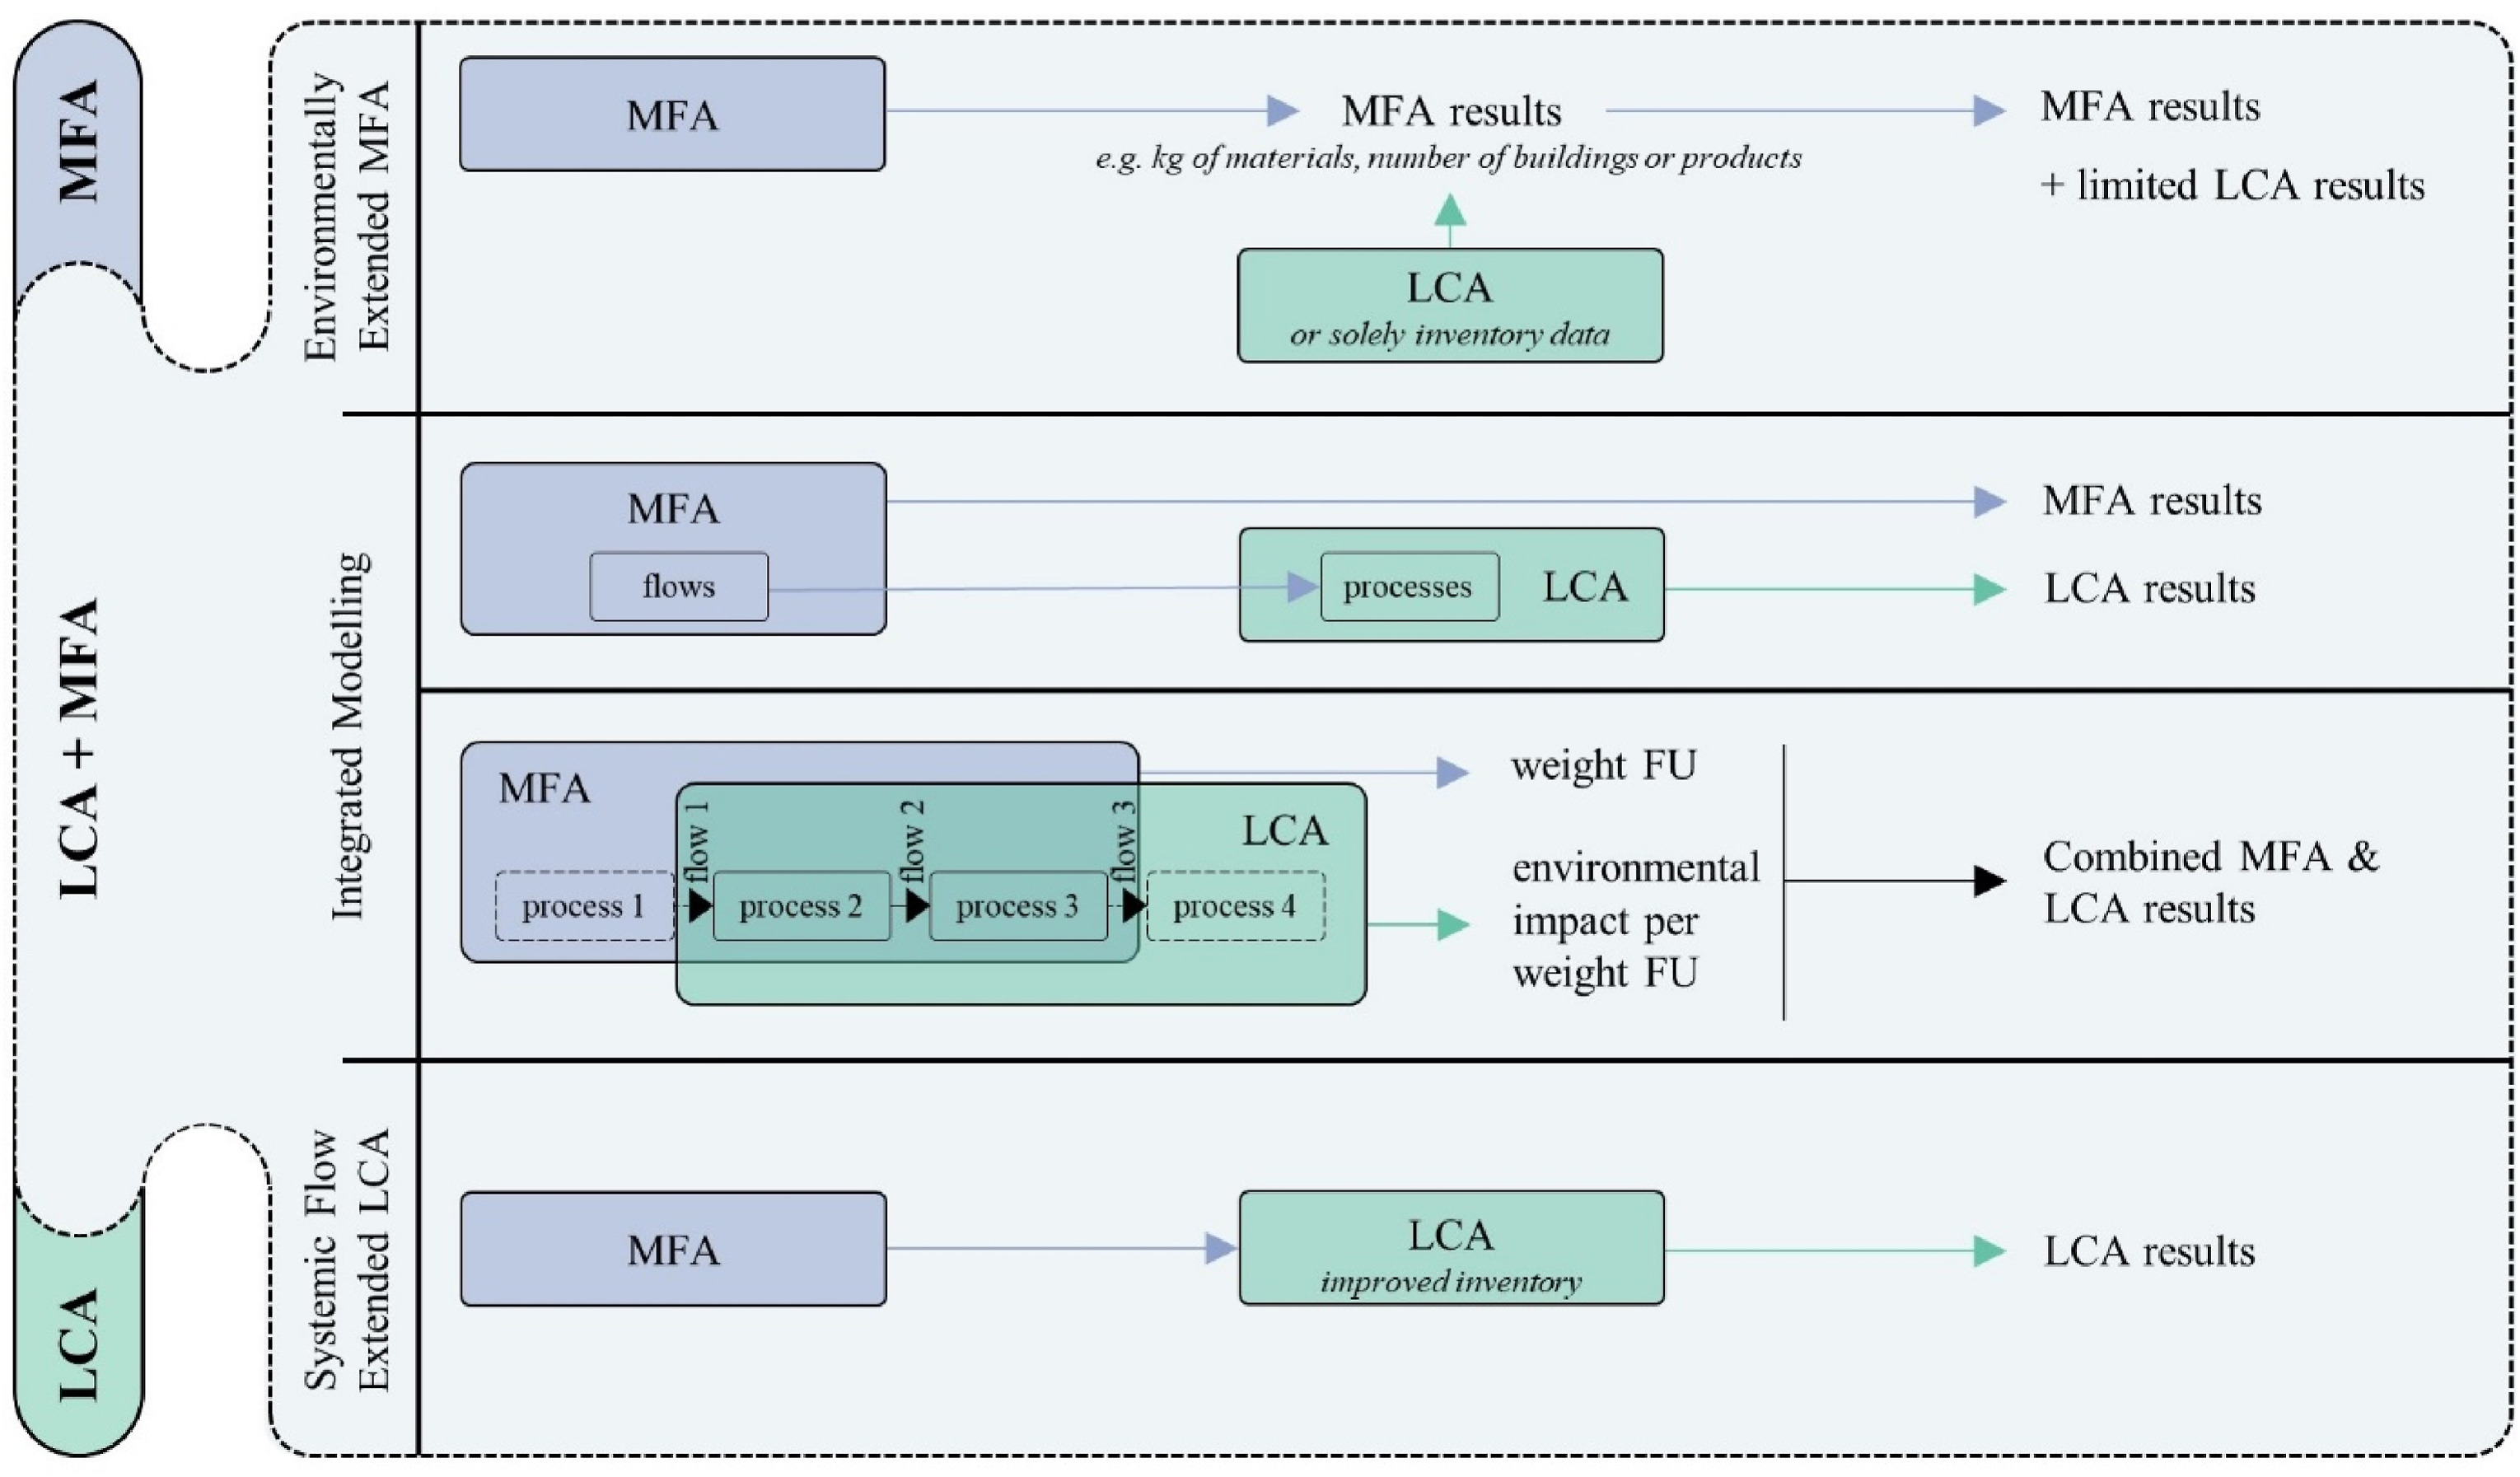

1. Barkhausen, R., Rostek, L., Miao, Z. C., & Zeller, V. (2023). Combinations of material flow analysis and life cycle assessment and their applicability to assess circular economy requirements in EU product regulations. A systematic literature review. Journal of Cleaner Production, 137017.  https://doi.org/10.1016/j.jclepro.2023.137017